In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score
import seaborn as sns
from openai import OpenAI

In [29]:
df = pd.read_excel(r"C:\Users\Dnin\Desktop\bidnet_dataset_02122024_V1.xlsx")
df.head()

,Title,Description,Tags,Relevant?,Remarks
0,"E-Rate Cat. 2 - Wireless Network, UPS units, D...",The Denver Public Library (DPL) is seeking pro...,None,No,NaN
1,009-24 RFP Interpretation and Translation Serv...,DCSD is requesting proposals from qualified fi...,None,No,NaN
2,Survive and Thrive: Application and Payment Pr...,Boulder County Department of Housing and Human...,None,No,NaN
3,Parking Garage & Parking Lot Security Services,The City of Colorado Springs Parking System En...,None,No,NaN
4,Eaton UPS Replacements FY24,The University of Northern Colorado (“Universi...,None,No,NaN


In [30]:
df['Description'] = df['Title'].fillna('') + ' - ' + df['Description'].fillna('')

df['Relevant?'] = df['Relevant?'].map({'Yes': True, 'No': False}).astype(bool)

df['Tags'] = df['Tags'].apply(lambda x:[tag.strip() for tag in x.split(',')] if x != "None" else [])

In [31]:
client = OpenAI(api_key="***")
model = "gpt-3.5-turbo-0125"

In [48]:
def chatGPTResponse(row, model):
    description = row['Description']
    completion = client.chat.completions.create(
      model=model,
      messages=[
        {"role": "system", 
         "content": "Your task is to evaluate Request for Proposals (RFPs) and determine their relevance to our company's services and expertise areas. These RFPs are sourced from a portal, and our decision to pursue them depends on their alignment with specific keywords. The keywords include: digital transformation, artificial intelligence, machine learning, analytics, data engineering, salesforce, grants, licensing, permits, lightning experience, lightning migration, case management, data warehouse, automation, RPA (robotic process automation), advisory, application development, document management, apex, visualforce, einstein analytics, tableau, power bi, crm. You must carefully assess the context in which these keywords appear in the RFP description to ensure an accurate match. You will only respond with the keyword the description matches the most with. If there's no match, respond with 'No'. In cases of ambiguity or multiple relevant keywords, provide the best match based on the description's emphasis. We prioritize capturing potential opportunities, even at the risk of including less relevant RFPs."},
        {"role": "user", "content": f"Description - {description}"}
      ]
    )
    response = completion.choices[0].message.content
    tokens_used = completion.usage.total_tokens
    return response, tokens_used

def check_relevance(row):
    relevance = False if 'No' in row['Relevant Tags'] else True
    return relevance

In [49]:
# print("Response:" ,completion.choices[0].message.content)
# print("Tokens Used:" ,completion.usage.total_tokens)

In [50]:
df[['Relevant Tags','Tokens']] = df.apply(lambda row: chatGPTResponse(row,model), axis=1,result_type='expand')

In [51]:
total_tokens_used = df['Tokens'].sum()
cost = (total_tokens_used/1000) * 0.0005
print(cost)

0.023245000000000002


In [52]:
df['Predicted Relevance'] = df.apply(check_relevance, axis=1)

In [53]:
precision = precision_score(df['Relevant?'], df['Predicted Relevance'])
recall = recall_score(df['Relevant?'], df['Predicted Relevance'])
accuracy = accuracy_score(df['Relevant?'], df['Predicted Relevance'])

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

Precision: 0.8333333333333334
Recall: 0.8695652173913043
Accuracy: 0.9461538461538461


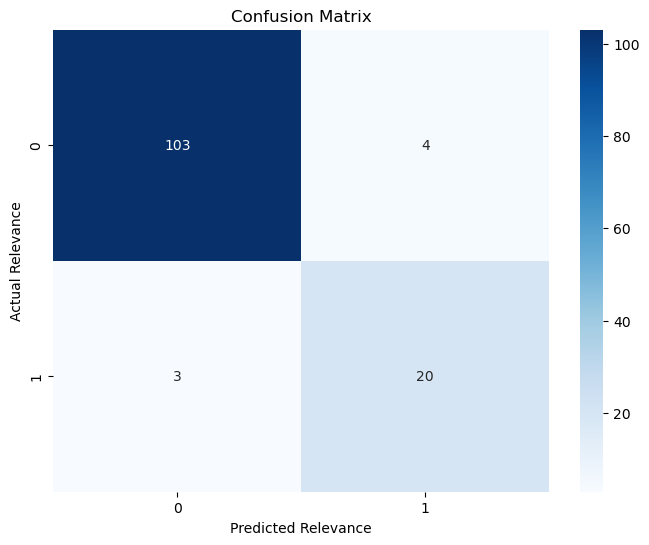

In [54]:
conf_mat = confusion_matrix(df['Relevant?'], df['Predicted Relevance'])
# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Relevance')
plt.ylabel('Actual Relevance')
plt.show()

In [58]:
df.loc[(df['Relevant?'] == False) & (df['Predicted Relevance'] == True)]

,Title,Description,Tags,Relevant?,Remarks,Relevant Tags,Tokens,Predicted Relevance
5,Enterprise Resource Planning Readiness Consultant,Enterprise Resource Planning Readiness Consult...,[],False,Its not relevant but its okay if its classifie...,Automation,356,True
13,Labor Market Data Tool,Labor Market Data Tool - CDLE is seeking quota...,[],False,NaN,analytics,404,True
26,Leave Management Software,Leave Management Software - Weld County is loo...,[],False,NaN,RPA (robotic process automation),273,True
79,Town of Buena Vista Comprehensive Plan 2024,Town of Buena Vista Comprehensive Plan 2024 - ...,[],False,NaN,Grants,592,True


In [57]:
df.loc[(df['Relevant?'] == True) & (df['Predicted Relevance'] == False)]

,Title,Description,Tags,Relevant?,Remarks,Relevant Tags,Tokens,Predicted Relevance
15,"FAMLI PREMIUMS, BENEFITS AND DMS SYSTEM IMPLEM...","FAMLI PREMIUMS, BENEFITS AND DMS SYSTEM IMPLEM...","[digital transformation, document management]",True,NaN,No,472,False
24,"RFP# 1173 - Website Monitoring, Support, and D...","RFP# 1173 - Website Monitoring, Support, and D...",[application development],True,NaN,No,362,False
41,"Inventory, Recipe, and Menu Management Software","Inventory, Recipe, and Menu Management Softwar...",[application development],True,NaN,No,305,False


In [60]:
from openai import OpenAI

def semantic_search(api_key, description):
    client = OpenAI(api_key=api_key)
    model = "gpt-3.5-turbo-0125"
    
    completion = client.chat.completions.create(
      model=model,
      messages=[
        {"role": "system", 
         "content": "Your task is to evaluate Request for Proposals (RFPs) and determine their relevance to our company's services and expertise areas. These RFPs are sourced from a portal, and our decision to pursue them depends on their alignment with specific keywords. The keywords include: digital transformation, artificial intelligence, machine learning, analytics, data engineering, salesforce, grants, licensing, permits, lightning experience, lightning migration, case management, data warehouse, automation, RPA (robotic process automation), advisory, application development, document management, apex, visualforce, einstein analytics, tableau, power bi, crm. You must carefully assess the context in which these keywords appear in the RFP description to ensure an accurate match. You will only respond with the keyword the description matches the most with. If there's no match, respond with 'No'. In cases of ambiguity or multiple relevant keywords, provide the best match based on the description's emphasis. We prioritize capturing potential opportunities, even at the risk of including less relevant RFPs."},
        {"role": "user", "content": f"Description - {description}"}
      ]
    )
    response = completion.choices[0].message.content
    return response

In [61]:
print(semantic_search("***","Digital Adoption Platform license to use for in-app training with the move to Oracle HCM/ERP, as well as other programs to better support the long-term training strategy set forth by the district"))

licensing
